# Erros redutíveis e irredutível.

$$\lim_{N \to \infty} \frac{1}{N} \sum_{n=0}^{N-1} (y_{noisy} - \hat{y})^2 
%
\\ = E[(y_{noisy} - \hat{y})^2].
$$

Lembrando que $y_{noisy} = y + w$, então
$$E[(y_{noisy} - \hat{y})^2] = E[(y + w - \hat{y})^2].$$

Expandindo a equação acima e agrupando alguns termos, temos

$$ E[ (y - \hat{y})^2 + 2 w (y - \hat{y}) + w^2  ].$$

Como $w$ é ruído branco Gaussiano, então $E[w] = 0$, e, desta forma, a equação acima pode ser simplificada para

$$E[ (y - \hat{y})^2 + w^2  ] \\= E[ (y - \hat{y})^2 ] + E[ w^2 ],$$

onde o primeiro termo é o **erro redutível** e o segundo termo o **erro irredutível**, aquele devido ao ruído e que não conseguimos dimunuir.

Conseguimos expandir o primeiro termo e identificar a **variância** e o **bias** deste estimador. Assumindo que os valores de $y$ não são aleatórios, podemos re-escrever o segundo termo como

$$E[ (y - \hat{y})^2 ] = y^2 -2 y E[\hat{y}] + E[\hat{y}^2].$$

O último termo pode ser re-escrito como $E[\hat{y}^2] = \text{var}(\hat{y}) + E[\hat{y}]^2$, e, então, temos

$$E[ (y - \hat{y})^2 ] = (y - E[\hat{y}])^2 + \text{var}(\hat{y}).$$

O primeiro termo da equação acima nos dá o valor do **bias** ao quadrado, enquanto o segundo termo nos dá a **variância** do estimador.

Portanto, 

$$E[(y_{noisy} - \hat{y})^2] = \text{bias}(\hat{y})^2 + \text{var}(\hat{y}) + \text{var}(w).$$

Os dois primeiros termos são sempre positivos e portanto $E[(y_{noisy} - \hat{y})^2]$ nunca será igual a zero se $\text{var}(w) \neq 0$. Também podemos ver que para minimizar o erro, devemos ter ambos valores, **bias** e **variâncias** com os menores valores possíveis. Portanto, para se ter um modelo que generalize bem, ambos valores devem ser pequenos.

In [31]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
!pip install mlxtend
from mlxtend.evaluate import bias_variance_decomp

In [14]:
# Reset pseudo random number generator so that the results are reproducible.
seed = 42

In [15]:
def genTargetFunction(N):
    # Attribute.
    x1 = np.linspace(-3, 3, N).reshape(N, 1)
    # Create target function.
    y = x1 + 0.5*x1**2
    # Noisy version of the target function.
    y_noisy = y + np.random.randn(N, 1)
    return x1, y_noisy, y

In [22]:
# Number of examples.
N = 50

# Polinomial degrees to be tested.
degrees = [1, 2, 40]

# Include column of ones once the target function has a bias.
include_bias = True

repetitions = 1000

mse_train = np.zeros((len(degrees), repetitions))
mse_val = np.zeros((len(degrees), repetitions))
mse_orig = np.zeros((len(degrees), repetitions))

for i in range(len(degrees)):
    
    np.random.seed(seed)
    
    for k in range(repetitions):
    
        x1, y_noisy, y = genTargetFunction(N)

        x1_train, x1_val, y_train, y_val, y_orig_train, y_orig_val = train_test_split(x1, y_noisy, y, test_size=0.2, random_state=seed)

        # Instantiate a polynomial with the given degree.
        poly = PolynomialFeatures(degree=degrees[i], include_bias=include_bias)
        # Instantiate a scaler that will standardize the features.
        scaler = StandardScaler()
        # Instantiate a linear regressor.
        reg = LinearRegression()

        # Create a pipeline of actions.
        poly_reg = Pipeline([
            ("poly", poly),
            ("scaler", scaler),
            ("reg", reg),
        ])

        # Train the polinomial model, i.e., the hypothesis.
        poly_reg.fit(x1_train, y_train)

        # Use the trained model for prediction.
        ypred_train = poly_reg.predict(x1_train)
        ypred_val = poly_reg.predict(x1_val)

        # Calculate the Mean Squared Error (MSE) between target and predicted values.
        mse_train[i][k] = mean_squared_error(y_train, ypred_train)
        mse_val[i][k] = mean_squared_error(y_val, ypred_val)
        mse_orig[i][k] = mean_squared_error(y_orig_train, ypred_train) 

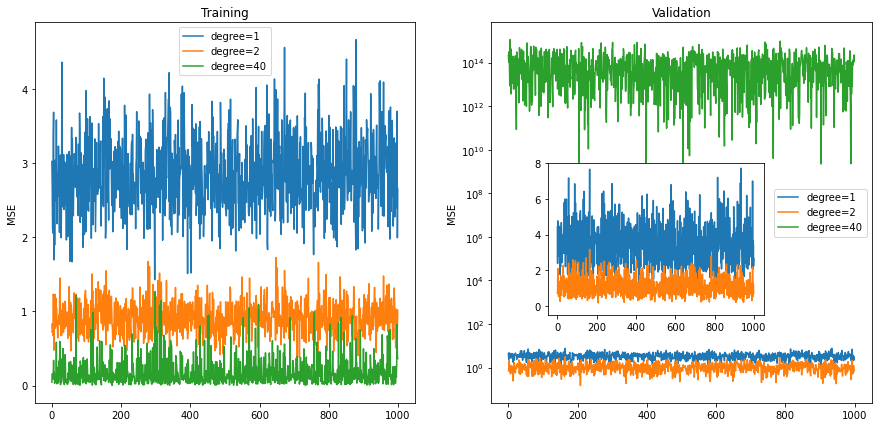

In [23]:
fig = plt.figure(figsize=(15, 7))

ax = plt.subplot(1, 2, 1)
plt.plot(mse_train[0][:], label='degree=1')
plt.plot(mse_train[1][:], label='degree=2')
plt.plot(mse_train[2][:], label='degree=40')
plt.title('Training')
plt.ylabel('MSE')
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(mse_val[0][:], label='degree=1')
plt.plot(mse_val[1][:], label='degree=2')
plt.plot(mse_val[2][:], label='degree=40')
plt.yscale('log')
plt.ylabel('MSE')
plt.title('Validation')
plt.legend()

left, bottom, width, height = [0.6, 0.3, 0.2, 0.3]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.plot(mse_val[0][:], label='degree=1')
ax3.plot(mse_val[1][:], label='degree=2')
ax3.plot(mse_val[2][:], label='degree=40')
ax3.set_ylim(-0.5, 8)

plt.show()

In [24]:
mean_mse_train = []
mean_mse_val = []
var_mse_train = []
var_mse_val = []
mean_mse_orig = []
var_mse_orig = []
for i in range(len(degrees)):
    mean_mse_train.append(np.mean(mse_train[i][:]))
    mean_mse_val.append(np.mean(mse_val[i][:]))
    var_mse_train.append(np.var(mse_train[i][:]))
    var_mse_val.append(np.var(mse_val[i][:]))
    mean_mse_orig.append(np.mean(mse_orig[i][:]))
    var_mse_orig.append(np.var(mse_orig[i][:]))

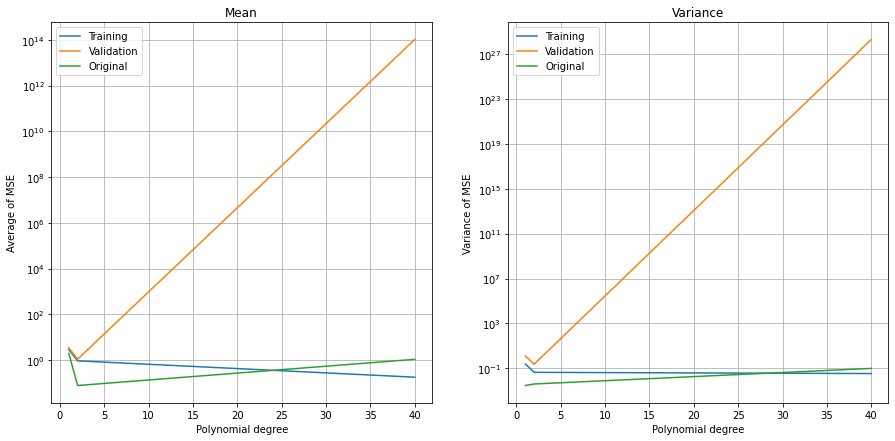

In [25]:
fig = plt.figure(figsize=(15, 7))

ax = plt.subplot(1, 2, 1)
plt.title('Mean')
plt.plot(degrees, mean_mse_train, label='Training')
plt.plot(degrees, mean_mse_val, label='Validation')
plt.plot(degrees, mean_mse_orig, label='Original')
plt.ylabel('Average of MSE')
plt.xlabel('Polynomial degree')
plt.yscale('log')
plt.grid()
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(degrees, var_mse_train, label='Training')
plt.plot(degrees, var_mse_val, label='Validation')
plt.plot(degrees, var_mse_orig, label='Original')
plt.title('Variance')
plt.ylabel('Variance of MSE')
plt.xlabel('Polynomial degree')
plt.yscale('log')
plt.grid()
plt.legend()

plt.show()

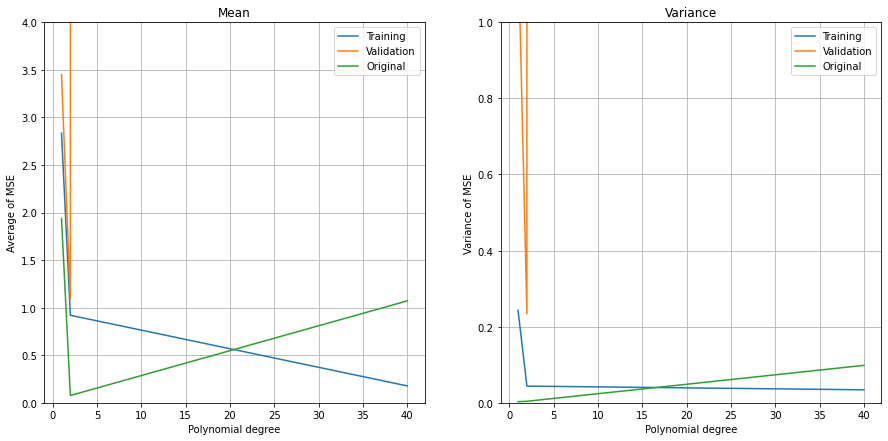

In [28]:
fig = plt.figure(figsize=(15, 7))

ax = plt.subplot(1, 2, 1)
plt.title('Mean')
plt.plot(degrees, mean_mse_train, label='Training')
plt.plot(degrees, mean_mse_val, label='Validation')
plt.plot(degrees, mean_mse_orig, label='Original')
plt.ylabel('Average of MSE')
plt.xlabel('Polynomial degree')
plt.ylim(0,4)
plt.grid()
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(degrees, var_mse_train, label='Training')
plt.plot(degrees, var_mse_val, label='Validation')
plt.plot(degrees, var_mse_orig, label='Original')
plt.title('Variance')
plt.ylabel('Variance of MSE')
plt.xlabel('Polynomial degree')
plt.ylim(0,1)
plt.grid()
plt.legend()

plt.show()